
# Results for experiments over KDDCup dataset

In [1]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')
seaborn.set_palette('colorblind')

In [3]:
METRICS_COLS = ['AUC', 'RMSE', 'Accuracy', 'R2']

In [4]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [5]:
ANCHOR_COURSES = [1, 6, 16]

In [6]:
def read_predictions(filename):
    with open(filename, 'rb') as prediction_file:
        return pickle.load(prediction_file)

def read_file_metrics(true, predicted):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    try:
        results.append([metrics.roc_auc_score(true, predicted)])
    except ValueError:
        ignored_sequences += 1
        results.append([numpy.nan])
    results[-1].append(metrics.mean_squared_error(true, predicted)**0.5)
    results[-1].append(metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0)))
    results[-1].append(metrics.r2_score(true, predicted))
    results[-1].append(true.shape[0])
    if ignored_sequences > 0:    
        print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=METRICS_COLS + ['Support'])

In [7]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        trues, predictions = [], []
        for filename in get_runs(dirname):
            true, predicted = read_predictions(os.path.join(dirname, filename))
            file_metrics = read_file_metrics(true, predicted)
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                file_metrics['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                file_metrics['Course'] = 1
            metrics_dfs.append(file_metrics)
            trues.append(true)
            predictions.append(predicted)
        general_metrics = read_file_metrics(numpy.concatenate(trues), numpy.concatenate(predictions))
        general_metrics['Experiment'] = dirname[-16:]
        general_metrics['Run'] = -1
        general_metrics['Course'] = -1
        metrics_dfs.append(general_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True).set_index(['Experiment', 'Run', 'Course'])

In [33]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'], dtype=numpy.float32)
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'], dtype=numpy.float32)
            train['Dataset'] = 'train'
            validation['Dataset'] = 'validation'
            concat = pandas.concat([train, validation])
            concat['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                concat['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                concat['Course'] = 1
            concat['rmse'] = concat['mse']**0.5
            dataframes.append(concat)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    performances = []
    for dirname, performance_dataframe in train_performances.items():
        perf = performance_dataframe.groupby(['epoch', 'Run', 'Course']).agg({'rmse': 'std'}).groupby(
            'Course').agg('mean')
        perf['Experiment'] = dirname[-16:]
        performances.append(perf.reset_index())
    performances = pandas.concat(performances, ignore_index=True)
    seaborn.factorplot(x='Course', y='rmse', col="Experiment", data=performances, col_wrap=4)

def graphic_learning_curves(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['Run'] == '0'],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'Dataset').add_legend().set_xticklabels([])
        plt.show()

### Real distribution of labels

In [9]:
true, predicted = read_predictions('/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/predictions_c1_run0.p')
true.shape, true[true == 1].shape

((1700,), (1093,))

## Experiments with LSTM model

In [41]:
LSTM_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/',
    #'/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/',
    #'/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/',
    #'/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-17-13-47/',
]

## Learning curves

In [42]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

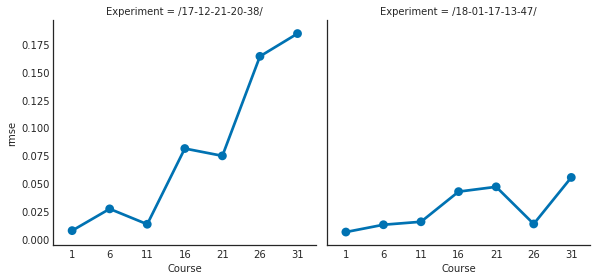

In [43]:
graphic_performances(lstm_performances)

In [ ]:
for dirname, dataframe in lstm_performances.items():
    print(dirname)
    idx = dataframe.groupby(['Dataset', 'Course'])['epoch'].transform(max) == dataframe['epoch']
    display(dataframe[idx].groupby(['Course', 'Dataset']).agg('mean'))

## Performance Metrics

In [45]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [46]:
lstm_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/17-12-21-20-38/ -1      0.814149  0.373602  0.821944  0.308482
                  1      0.881006  0.361324  0.822059  0.430561
                  6      0.803861  0.335795  0.863571  0.314949
                  11     0.738556  0.357680  0.837500  0.108718
                  16     0.666461  0.490281  0.713333 -0.108186
                  21     0.626165  0.404719  0.795000 -0.094339
                  26     0.674197  0.272854  0.920000  0.198244
                  31     0.699818  0.463802  0.775000 -0.062171
/18-01-17-13-47/ -1      0.837232  0.335478  0.856614  0.345277
                  1      0.871481  0.341300  0.854722  0.449573
                  6      0.841756  0.289848  0.895408  0.368997
                  11     0.815269  0.298726  0.883973  0.244654
                  16     0.741369  0.386294  0.796380  0.153441
                  21     0.661904  0.418368  0.771318 -0.194712
                  26     0.863580  0.270556  0.912587  0.168719
                  31     0.820191  0.362831  0.827731  0.038607

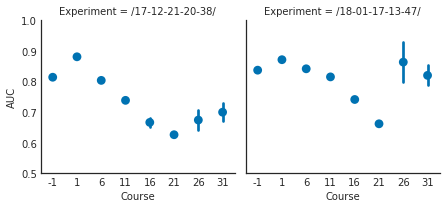

In [47]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.5, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

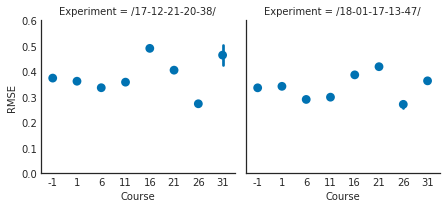

In [48]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with Embedded LSTM model

In [49]:
EMBEDDING_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/',
#      '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-59/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-11-05/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-19-28/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-21-04/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-03-17-53/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-03-10-28/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-33/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-49/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-15/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-58/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-11-14-38/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-18-40/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-19-06/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-13-21-15/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-17-14-01/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-17-14-46/',
]

## Learning curves

In [50]:
embedding_performances = read_performances(EMBEDDING_EXPERIMENTS_DIRS)

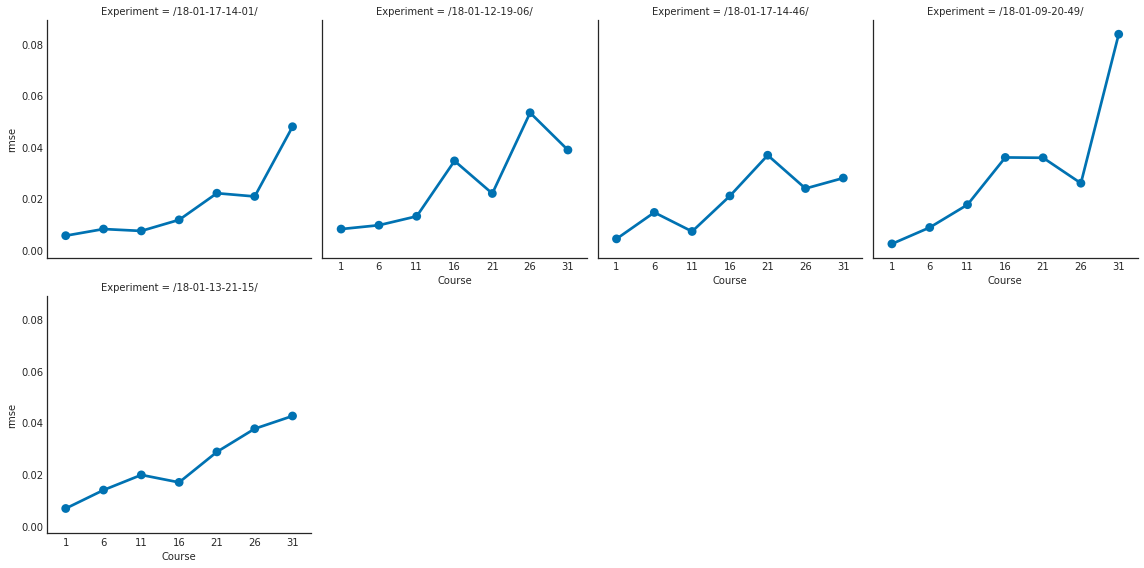

In [51]:
graphic_performances(embedding_performances)

## Performance Metrics

In [52]:
embedding_metrics = read_metrics(EMBEDDING_EXPERIMENTS_DIRS)

In [53]:
embedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-09-20-49/ -1      0.834144  0.361494  0.829268  0.343754
                  1      0.883644  0.357592  0.824627  0.442151
                  6      0.812601  0.333291  0.864810  0.322126
                  11     0.786582  0.327041  0.859743  0.206551
                  16     0.730769  0.455922  0.714506  0.042911
                  21     0.687500  0.374792  0.830645  0.050737
                  26     0.580944  0.327380  0.880368  0.003249
                  31     0.791613  0.410934  0.803922  0.150646
/18-01-12-19-06/ -1      0.834928  0.361778  0.827086  0.342723
                  1      0.879839  0.360713  0.822044  0.432409
                  6      0.814511  0.340267  0.846467  0.293432
                  11     0.774813  0.322827  0.872591  0.226761
                  16     0.722487  0.445336  0.736111  0.088709
                  21     0.712247  0.371045  0.822581  0.069070
                  26     0.693531  0.304827  0.892638  0.135853
                  31     0.757722  0.420008  0.784314  0.113790
/18-01-13-21-15/ -1      0.840968  0.360393  0.827471  0.347746
                  1      0.879650  0.363508  0.817738  0.423497
                  6      0.818702  0.333898  0.859375  0.319595
                  11     0.776497  0.322460  0.872591  0.228528
                  16     0.752753  0.431741  0.734568  0.144658
                  21     0.714672  0.371939  0.825806  0.065352
                  26     0.700175  0.299262  0.895706  0.168020
                  31     0.760940  0.421226  0.774510  0.108638
/18-01-17-14-01/ -1      0.849845  0.329682  0.862417  0.367703
                  1      0.887088  0.337781  0.852542  0.460796
                  6      0.850499  0.290615  0.895408  0.365689
                  11     0.805503  0.298939  0.891486  0.243663
                  16     0.782773  0.379327  0.806561  0.183768
                  21     0.699253  0.395770  0.812661 -0.069351
                  26     0.803225  0.271656  0.912587  0.163587
                  31     0.853369  0.328515  0.863445  0.207883
/18-01-17-14-46/ -1      0.846377  0.328070  0.862417  0.373871
                  1      0.879428  0.338815  0.852058  0.457564
                  6      0.843054  0.288996  0.895918  0.372727
                  11     0.803427  0.294921  0.892321  0.263860
                  16     0.788014  0.370606  0.820136  0.219406
                  21     0.652333  0.399210  0.803618 -0.088751
                  26     0.739964  0.268332  0.914336  0.180211
                  31     0.887579  0.313719  0.850840  0.277355

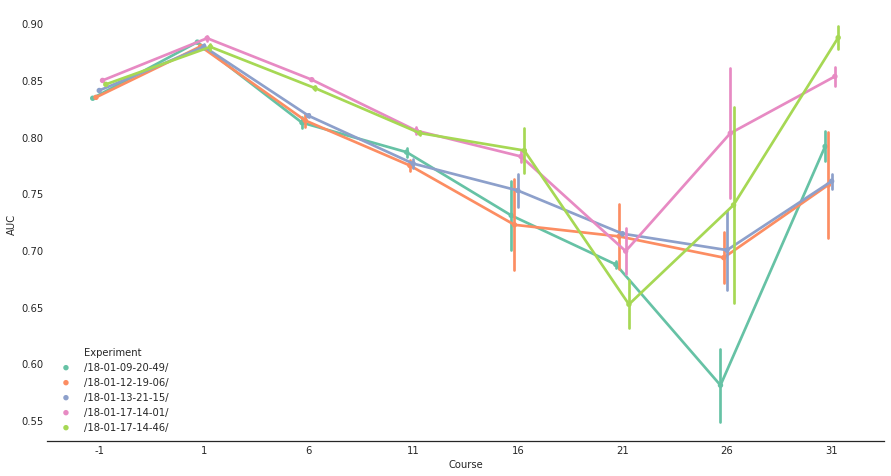

In [54]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

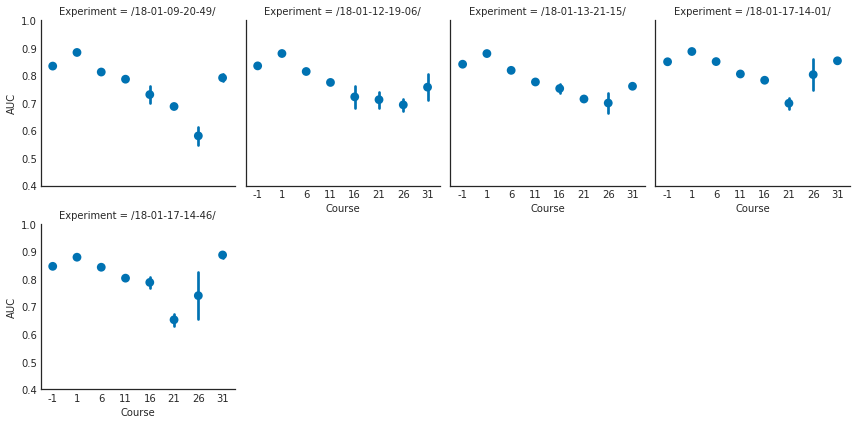

In [55]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.4, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

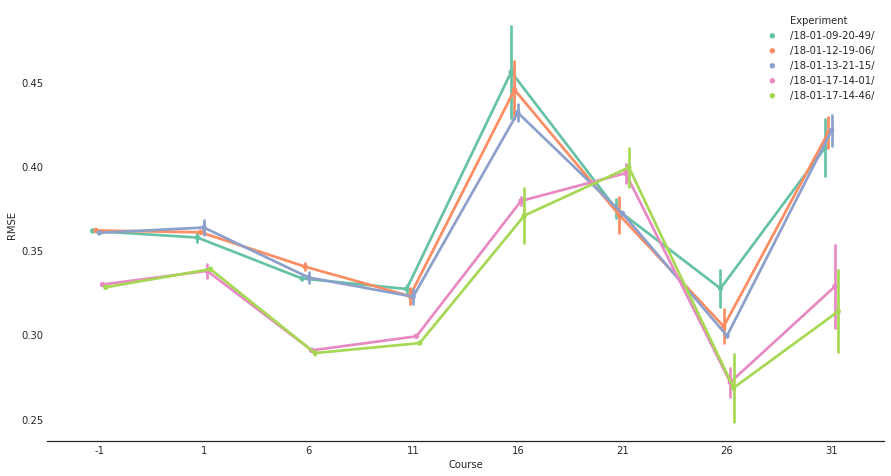

In [56]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

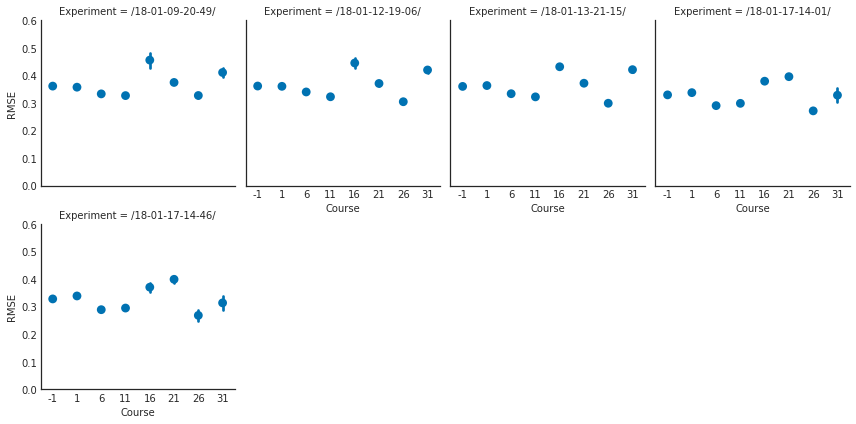

In [57]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with CO-Embedde LSTM model

In [70]:
COEMBEDDING_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-09/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-57/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-20-56/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-13/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-22/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-03-12-22/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-04-09-45/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-05-17-37/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-09-18-19/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-18-46/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-20-18/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-14-18/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-23-03/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-11-16-32/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-09-49/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-10-31/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-13-20-35/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-17-15-29/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-17-16-25/',
]

## Learning curves

In [71]:
coembedding_performances = read_performances(COEMBEDDING_EXPERIMENTS_DIRS)

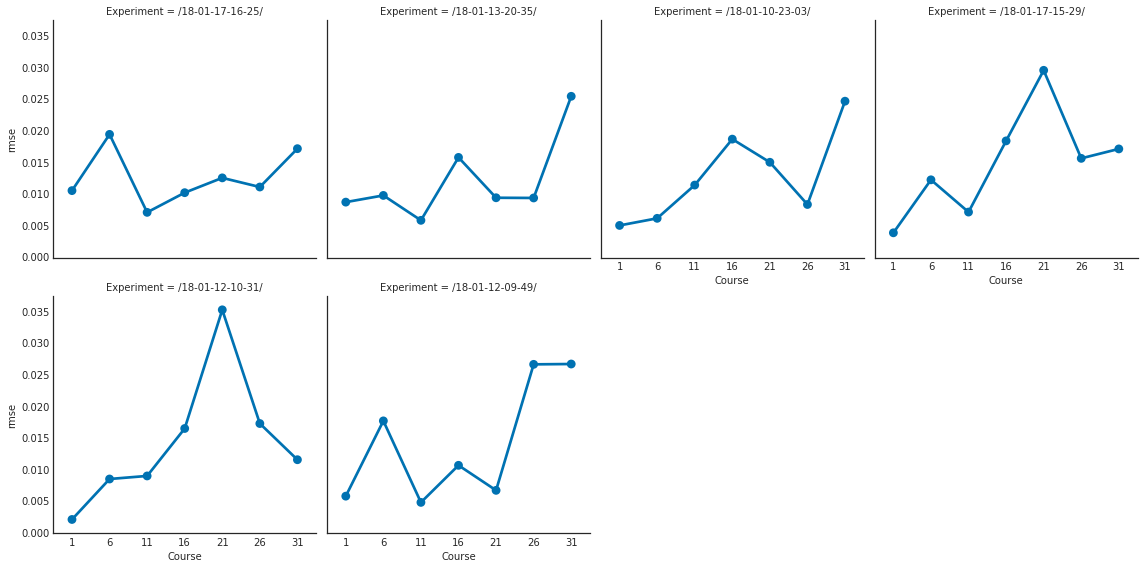

In [72]:
graphic_performances(coembedding_performances)

## Performance Metrics

In [73]:
coembedding_metrics = read_metrics(COEMBEDDING_EXPERIMENTS_DIRS)

In [74]:
coembedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-10-23-03/ -1      0.843817  0.357996  0.831451  0.356392
                  1      0.876899  0.364666  0.825201  0.419711
                  6      0.817327  0.332207  0.864810  0.326526
                  11     0.779796  0.320291  0.872591  0.238962
                  16     0.734309  0.441519  0.725309  0.105543
                  21     0.775977  0.353376  0.820968  0.156183
                  26     0.729196  0.304099  0.892638  0.140768
                  31     0.837087  0.373665  0.797386  0.298908
/18-01-12-09-49/ -1      0.850923  0.352285  0.835558  0.376761
                  1      0.880606  0.356679  0.832090  0.445030
                  6      0.812556  0.334801  0.859375  0.315947
                  11     0.769473  0.329762  0.864026  0.193021
                  16     0.771001  0.416382  0.751543  0.204462
                  21     0.787191  0.348344  0.837097  0.180162
                  26     0.802622  0.288014  0.892638  0.229384
                  31     0.854569  0.371763  0.787582  0.305972
/18-01-12-10-31/ -1      0.848024  0.356076  0.829012  0.363275
                  1      0.876172  0.363383  0.824914  0.423972
                  6      0.810731  0.331359  0.857337  0.329965
                  11     0.759065  0.335116  0.852248  0.166895
                  16     0.766455  0.419695  0.742284  0.191575
                  21     0.759280  0.356181  0.819355  0.142558
                  26     0.795629  0.273261  0.904908  0.306248
                  31     0.839339  0.378614  0.790850  0.279411
/18-01-13-20-35/ -1      0.848479  0.355239  0.828498  0.366268
                  1      0.878350  0.359879  0.825488  0.435017
                  6      0.808552  0.338100  0.850543  0.302287
                  11     0.774609  0.329601  0.847966  0.194045
                  16     0.768247  0.415795  0.751543  0.206778
                  21     0.762233  0.355264  0.824194  0.147181
                  26     0.790210  0.290657  0.895706  0.214648
                  31     0.824110  0.379997  0.797386  0.274848
/18-01-17-15-29/ -1      0.854010  0.327061  0.857414  0.377719
                  1      0.883751  0.343786  0.838983  0.441283
                  6      0.852571  0.286743  0.896939  0.382462
                  11     0.796799  0.307157  0.871452  0.200848
                  16     0.814422  0.357069  0.831448  0.276777
                  21     0.749499  0.370717  0.816537  0.061916
                  26     0.686739  0.278930  0.912587  0.118700
                  31     0.887643  0.299946  0.867647  0.343319
/18-01-17-16-25/ -1      0.849586  0.324981  0.863618  0.385610
                  1      0.867446  0.343156  0.852300  0.443575
                  6      0.827591  0.291096  0.894898  0.363583
                  11     0.788449  0.302295  0.878130  0.226558
                  16     0.780726  0.362587  0.828054  0.254249
                  21     0.763513  0.355749  0.817829  0.136099
                  26     0.822674  0.250490  0.912587  0.289229
                  31     0.898080  0.302296  0.878151  0.332942

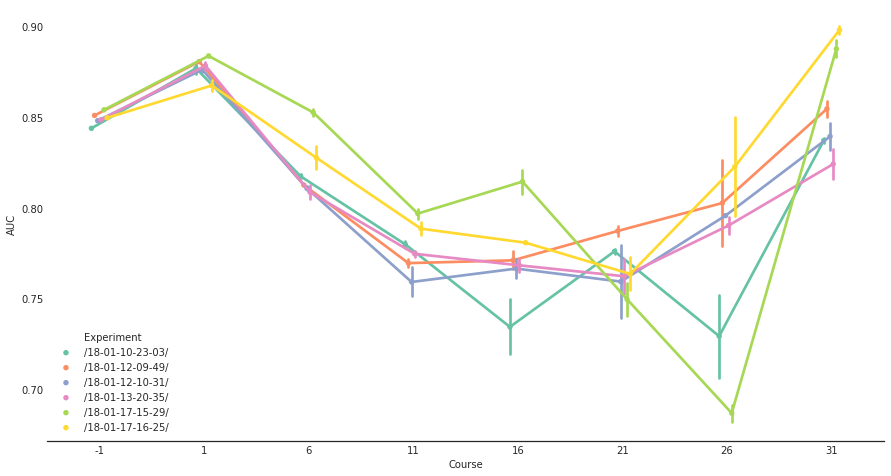

In [75]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

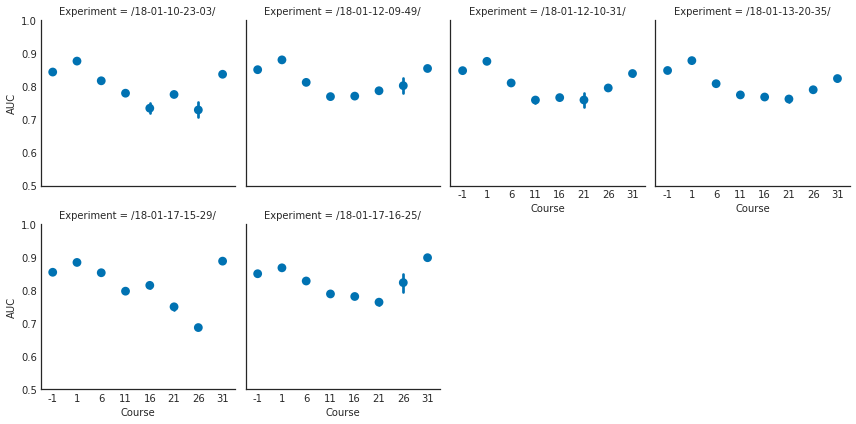

In [76]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0.5, 1], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

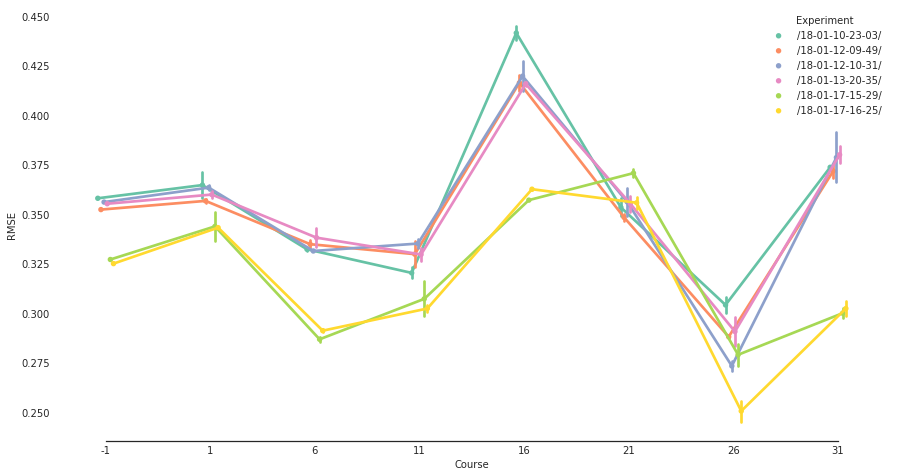

In [77]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True, trim=True)

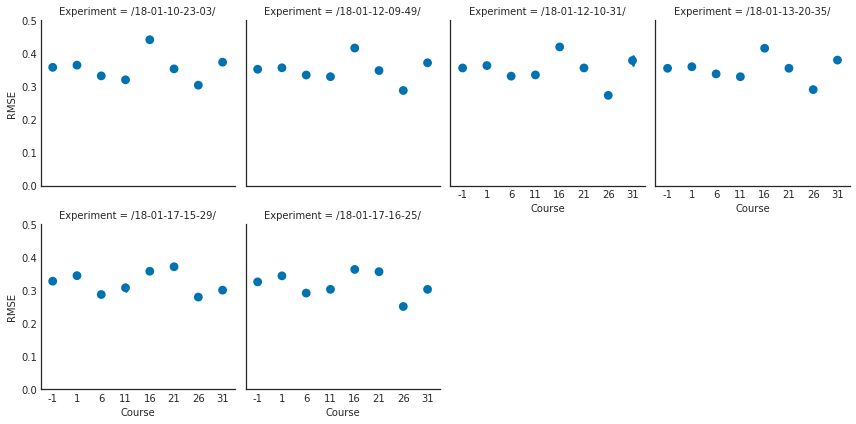

In [78]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0, 0.5], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)